# **Assignment - 3**

|     \    |  \        |
|------------------|----------------|
| Submitted by     | Yug Patel      |
| Roll Number      | CS23MTECH14019|




### 1. Self-Attention for Object Recognition with CNNs

- The problem can be implented using two flavor of weight matrics dimensions:

  1. $W_i \in \mathbb{R}^ {(H \times W) \times (H \times W)}$
  2. $W_i \in \mathbb{R}^ {C' \times (H \times W)}$
    
  &nbsp;&nbsp;&nbsp;&nbsp; $ \small Where:$\
  &nbsp;&nbsp;&nbsp;&nbsp; $ \small i = \{ Q, K, V \}$\
  &nbsp;&nbsp;&nbsp;&nbsp; $ \small C'= Output Channel$\
  &nbsp;&nbsp;&nbsp;&nbsp; $ \small C = Input Channel$\
  &nbsp;&nbsp;&nbsp;&nbsp; $ \small H = Height$\
  &nbsp;&nbsp;&nbsp;&nbsp; $ \small W = Width$

- As seen above, there are two approaches to solve the problem of Self-Attention for Object Recognition with CNNs. First Approach assumes C as constant and can change the (H x W) whereas the second assumes the (H x W) as constant and can chnage C. In other words the first approach flattens pixel pool over (H x W), having C number of tokens. And the seond approach logically flattens the C (depth), having (H x W) number of tokens. Also the second approach can be achieved using *_1 x 1_* convolution layer.<br>
- However, it is evident that using the second approach results in an increase in the weight matrix compared to the first approach. Therefore, I have opted for the second approach to ensure that the deep learning network has fewer parameters, leading to reduced computational costs.

- So this approach corresponds to the Network Architecture portrayed below:


 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;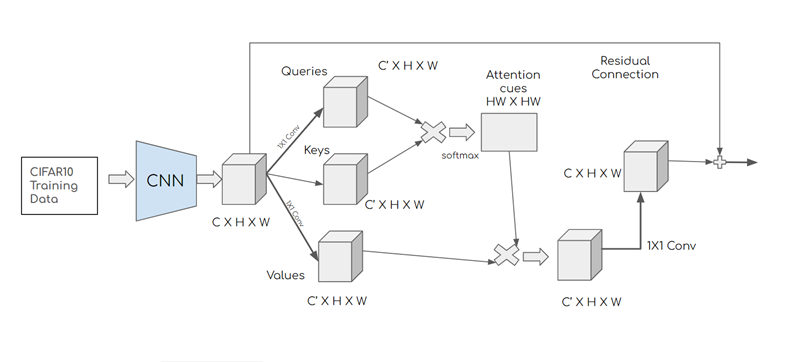


##### Importing required Modules

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

np.random.seed(0)
torch.manual_seed(0)

##### Self-Attention Layer
- The SelfAttention module performs self-attention on the input feature map, allowing the model to focus on relevant spatial and channel-wise information. It achieves this by computing attention scores between query and key representations and then using these scores to weight the corresponding values. The resulting attended values are combined with the original input through a residual connection, controlled by a learnable parameter gamma. This mechanism enhances the model's ability to capture long-range dependencies and improve feature representation, which can be beneficial for various tasks such as image recognition.


- It can be seen that the Linear Transformation of the image happens using a _*1 x 1*_ convolution layer as mentioned above\


- Typically, we set: $ \small C^* = C/8$. So I have used the same.


- It logically performs following mathematical computation:

  - $Q = {W_Q \times x}$
  - $K = {W_K \times x}$
  - $V = {W_V \times x}$
  - $\text{Attention cues = softmax}(Q^TK)_{ij} = \frac{e^{Q^TK_{ij}}}{\sum_{k=1}^{N} e^{Q^TK_{ik}}}$

  - $\text{Attention map = attention cues} \times V^T$
    
  - $\text{Residual connection} = \gamma \times \text{Attention map} + \mathbf{x}$


    

    

In [ ]:
# Define the Self-Attention Layer
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1, bias=False)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1, bias=False)
        self.value_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1, bias=False)
        self.out_conv = nn.Conv2d(in_channels // 8, in_channels, kernel_size=1, bias=False)
        self.gamma = nn.Parameter(torch.zeros(1))
        # self.batch_norm = nn.BatchNorm2d(in_channels)


    def forward(self, x):
        batch_size, channels, width, height = x.size()

        # Project input features into query, key, and value
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = F.softmax(energy, dim=-1)

        proj_value = self.value_conv(x).view(batch_size, -1, width * height)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1)).view(batch_size, channels // 8, width, height)
        out = self.out_conv(out)
        out = self.gamma * out + x
        return out

##### CNN with Self attention
- The SelfAttentionCNN model combines convolutional layers with batch normalization and self-attention modules to extract hierarchical features, stabilize training, and capture long-range dependencies. It utilizes a global average pooling layer for spatial aggregation and concludes with a fully connected layer for classification, making it effective for tasks like image recognition on datasets such as CIFAR-10.

In [ ]:
# Define the CNN Model with Self-Attention
class SelfAttentionCNN(nn.Module):
    def __init__(self):
        super(SelfAttentionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.sa1 = SelfAttention(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.sa2 = SelfAttention(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.sa3 = SelfAttention(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.sa4 = SelfAttention(256)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, 10)  # CIFAR-10 has 10 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.sa1(x)
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.sa2(x)
        x = self.bn2(x)
        x = F.relu(self.conv3(x))
        x = self.sa3(x)
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.sa4(x)
        x = self.bn4(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

##### Main Function
- It prepares the CIFAR10 dataset, instantiates a model, and trains it for 15 epochs. After that, the loss and accuracy are measured on the test set.

In [ ]:
# Load CIFAR-10 dataset and create data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Instantiate the model
model = SelfAttentionCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop with tqdm
num_epochs = 15
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.update(1)
            pbar.set_postfix({'Loss': running_loss / (len(train_loader))})

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Evaluation on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}')

Files already downloaded and verified
Files already downloaded and verified


Epoch 1/15: 100%|██████████| 782/782 [00:43<00:00, 18.08batch/s, Loss=1.39] 


Epoch 1/15, Loss: 1.3888


Epoch 2/15: 100%|██████████| 782/782 [00:43<00:00, 18.07batch/s, Loss=1.05] 


Epoch 2/15, Loss: 1.0542


Epoch 3/15: 100%|██████████| 782/782 [00:43<00:00, 18.10batch/s, Loss=0.899]


Epoch 3/15, Loss: 0.8987


Epoch 4/15: 100%|██████████| 782/782 [00:43<00:00, 18.11batch/s, Loss=0.79]  


Epoch 4/15, Loss: 0.7905


Epoch 5/15: 100%|██████████| 782/782 [00:43<00:00, 18.08batch/s, Loss=0.718] 


Epoch 5/15, Loss: 0.7178


Epoch 6/15: 100%|██████████| 782/782 [00:43<00:00, 18.08batch/s, Loss=0.655] 


Epoch 6/15, Loss: 0.6555


Epoch 7/15: 100%|██████████| 782/782 [00:43<00:00, 18.09batch/s, Loss=0.606] 


Epoch 7/15, Loss: 0.6060


Epoch 8/15: 100%|██████████| 782/782 [00:43<00:00, 18.12batch/s, Loss=0.57]  


Epoch 8/15, Loss: 0.5702


Epoch 9/15: 100%|██████████| 782/782 [00:43<00:00, 18.13batch/s, Loss=0.532] 


Epoch 9/15, Loss: 0.5316


Epoch 10/15: 100%|██████████| 782/782 [00:43<00:00, 18.05batch/s, Loss=0.496] 


Epoch 10/15, Loss: 0.4963


Epoch 11/15: 100%|██████████| 782/782 [00:43<00:00, 18.07batch/s, Loss=0.467] 


Epoch 11/15, Loss: 0.4665


Epoch 12/15: 100%|██████████| 782/782 [00:43<00:00, 18.12batch/s, Loss=0.446] 


Epoch 12/15, Loss: 0.4458


Epoch 13/15: 100%|██████████| 782/782 [00:43<00:00, 18.04batch/s, Loss=0.424] 


Epoch 13/15, Loss: 0.4245


Epoch 14/15: 100%|██████████| 782/782 [00:43<00:00, 18.10batch/s, Loss=0.413] 


Epoch 14/15, Loss: 0.4130


Epoch 15/15: 100%|██████████| 782/782 [00:43<00:00, 18.01batch/s, Loss=0.39]  


Epoch 15/15, Loss: 0.3904
Test Accuracy: 0.7879


### 2. Object Recognition with Vision Transformer
- The ViT implementation below follows the below architectural design:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;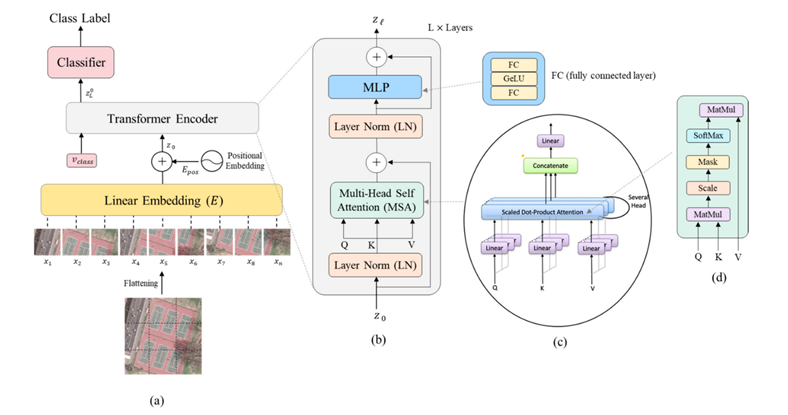

##### Importing Required Module

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from tqdm import tqdm, trange

np.random.seed(0)
torch.manual_seed(0)

##### Patchifying and Liner Transformation

1. Patchifying
  - The transformer encoder was developed with sequence data in mind, such as English sentences. However, an image is not a sequence. So function below sequencify an image.

  - $\small{(N, \#Patches, Patch dimensionality) = (N, P^2, \frac{HWC}{P^2}) }$

2. Linear Mapping/ Transformation
    - The linear mapping can map to any arbitrary vector size. Thus, we add a parameter to our class constructor, called hidden_d for _*‘hidden dimension’*_.

In [ ]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches**2, h * w * c // n_patches**2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[
                    :,
                    i * patch_size : (i + 1) * patch_size,
                    j * patch_size : (j + 1) * patch_size,
                ]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

##### Appending CLS (Classification) Token

- The first token of every input string is given by a special token (class), and the corresponding output of the model is ignored during training.

- This is a special token that we add to our model that has the role of capturing information about the other tokens

- When information about all other tokens will be present here, we will be able to classify the image using only this special token.

- The initial value of the special token is a parameter of the model that needs to be learned.

- The following code snippet does the same:

```` python
self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
````

##### Positional Encoding
- The positional embedding allows the network to know where each sub-image is positioned originally in the image. Without this information, the network would not be able to know where each such image would be placed, leading to potentially wrong predictions!

- In particular, positional encoding adds high-frequency values to the first dimensions and low-frequency values to the latter dimensions.

- In each sequence, for token i we add to its j-th coordinate the following value:

<br>

  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\text{Positional Encoding}(i, j) = \begin{cases}
  \sin(i / 10000^{j/d_{\text{model}}}) & \text{if } i \text{ is even} \\
  \cos(i / 10000^{(j-1)/d_{\text{model}}}) & \text{if } i \text{ is odd}
  \end{cases}
  $

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;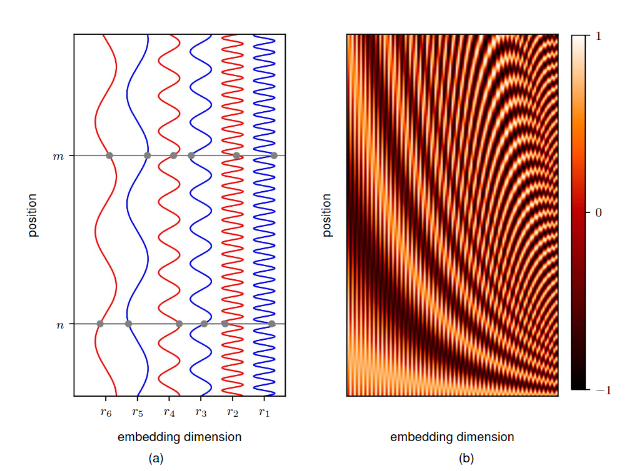

- From the heatmap, we can see that all ‘horizontal lines’ are all different from each other, and thus samples can be distinguished.

In [ ]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = (
                np.sin(i / (10000 ** (j / d)))
                if j % 2 == 0
                else np.cos(i / (10000 ** ((j - 1) / d)))
            )
    return result

##### Encoder Block

- The transformer encoders blocks, is composed of :
    - A Layer Normalization (LN), followed by a Multi-head Self Attention (MSA) and a residual connection.
        
    - Then a second LN, a Multi-Layer Perceptron (MLP), and again a residual connection.

- These blocks are connected back-to-back

In [ ]:

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MultiHeadSelfAttention, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                # seq = sequence[:, head * self.d_head : (head + 1) * self.d_head]
                q, k, v = q_mapping(sequence), k_mapping(sequence), v_mapping(sequence)

                attention = self.softmax(q @ k.T / (self.d_head**0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])


class ViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(ViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MultiHeadSelfAttention(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.ReLU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d),
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

##### Putting it all together

- All the above 4 steps in one place _*ViT*_ class i.e.

    1. Patchifying and Liner Transformation
    2. Appending CLS (Classification) Token
    3. Positional Embedding
    4. Encoder Block

In [ ]:

class ViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(ViT, self).__init__()

        # Attributes
        self.chw = chw  # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer(
            "positional_embeddings",
            get_positional_embeddings(n_patches**2 + 1, hidden_d),
            persistent=False,
        )

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList(
            [ViTBlock(hidden_d, n_heads) for _ in range(n_blocks)]
        )

        # 5) Classification MLPk
        self.mlp = nn.Sequential(nn.Linear(self.hidden_d, out_d), nn.Softmax(dim=-1))

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out)  # Map to output dimension, output category distribution


##### Main Function

In [ ]:
def main():

    # Loading data
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_set = datasets.CIFAR10(
        root="./root", train=True, download=True, transform=transform
    )
    test_set = datasets.CIFAR10(
        root="./root", train=False, download=True, transform=transform
    )

    train_loader = DataLoader(train_set, shuffle=True, batch_size=64)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=64)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "",)

    model = ViT((3, 32, 32), n_patches=8, n_blocks=6, hidden_d=8, n_heads=2, out_d=10).to(device)

    epochs = 5
    lr = 0.001

    # Training loop
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = CrossEntropyLoss()
    for epoch in trange(epochs, desc="Training"):
        model.train()
        train_loss = 0.0
        with tqdm(total=len(train_loader),desc =f"Epoch {epoch+1}/{epochs}",unit = 'batch') as pbar:
            for batch in train_loader:
                x, y = batch
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                y_hat = model(x)
                loss = criterion(y_hat, y)
                train_loss += loss.detach().cpu().item() / len(train_loader)
                loss.backward()
                optimizer.step()
                pbar.update(1)
                pbar.set_postfix({'Loss':train_loss})

        print(f"Epoch {epoch + 1}/{epochs} loss: {train_loss:.2f}")

    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")


if __name__ == "__main__":
    main()

Files already downloaded and verified
Files already downloaded and verified
Using device:  cuda (NVIDIA GeForce RTX 3090)


Training:  20%|██        | 1/5 [09:25<37:41, 565.35s/it]

Epoch 1/5 loss: 2.19


Training:  40%|████      | 2/5 [17:39<26:10, 523.38s/it]

Epoch 2/5 loss: 2.13


Training:  60%|██████    | 3/5 [25:41<16:48, 504.44s/it]

Epoch 3/5 loss: 2.11


Training:  80%|████████  | 4/5 [34:48<08:41, 521.26s/it]

Epoch 4/5 loss: 2.09


Training: 100%|██████████| 5/5 [43:01<00:00, 516.30s/it]


Epoch 5/5 loss: 2.07


Testing: 100%|██████████| 157/157 [00:44<00:00,  3.54it/s]

Test loss: 2.07
Test accuracy: 38.78%


### **NOTE:** The code was taking much time to get executed, so after making the file I runed it again for 10 epochs and got an accuracy of **48.42%**. The proof of same can be seen below:
### **It can be increased if you run it for more number of epochs.**

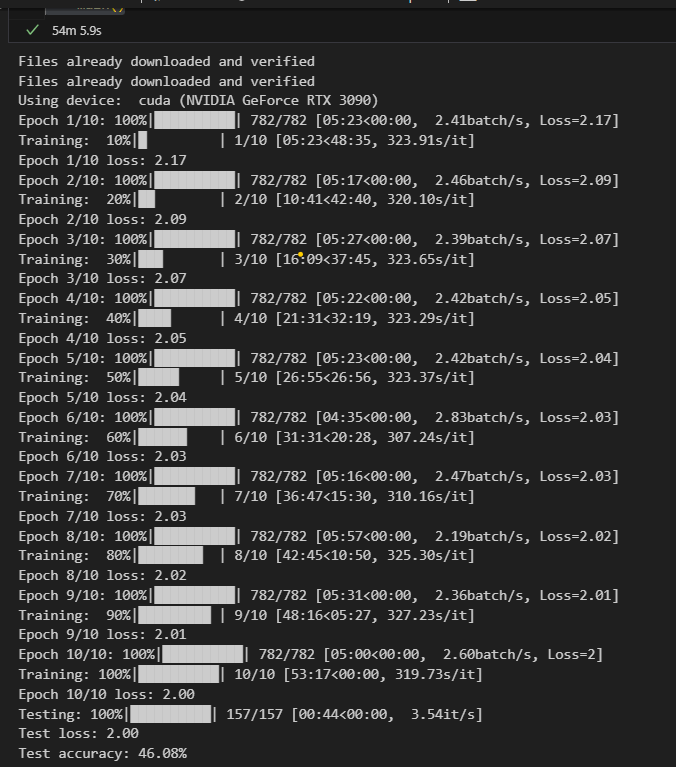

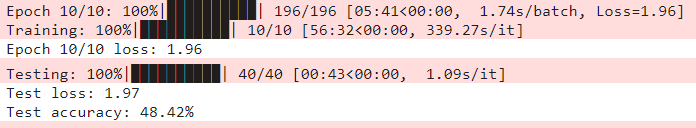

### Comparing the performance of the two implementations

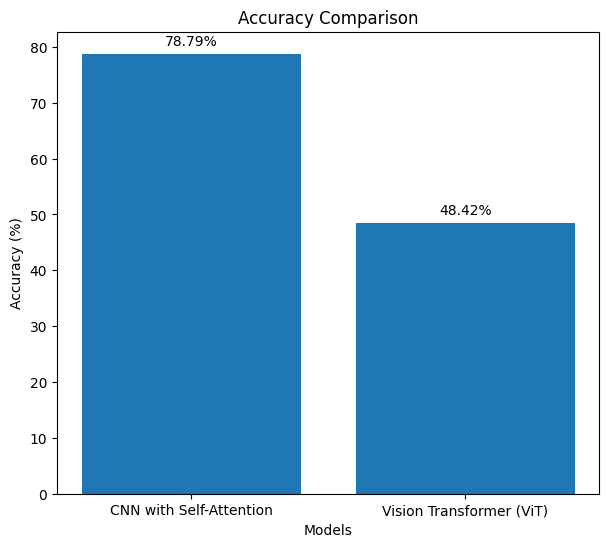

+---------------------------+--------------+
| Model                     | Accuracy (%) |
+---------------------------+--------------+
| CNN with Self-Attention   |      7.9e+01% |
| Vision Transformer (ViT)  |      4.8e+01% |
+---------------------------+--------------+


In [ ]:
import matplotlib.pyplot as plt

# Plot the accuracy comparison
labels = ['CNN with Self-Attention', 'Vision Transformer (ViT)']
accuracies = [78.79, 48.42]


plt.figure(figsize=(7, 6))
bars = plt.bar(labels, accuracies)
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison')
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{acc:.2f}%', ha='center', va='bottom')

plt.show()

# Creating a tabular comparison
print("+" + "-" * 27 + "+" + "-" * 14 + "+")
print("| {:<25} | {:>12} |".format("Model", "Accuracy (%)"))
print("+" + "-" * 27 + "+" + "-" * 14 + "+")
print("| {:<25} | {:>12.2}% |".format("CNN with Self-Attention", 78.79))
print("| {:<25} | {:>12.2}% |".format("Vision Transformer (ViT)",48.42))
print("+" + "-" * 27 + "+" + "-" * 14 + "+")